# LVM Data Simulator tutorial: advanced configuration and outputs

**In this tutorial we will show how to use the software to simulate different instrumental setups, different sky conditions and we will explain the different outputs produced by the code.**
- For a more basic description on how to install and setup the simulator, please refer to [tutorial #1](https://github.com/sdss/lvmdatasimulator/examples/LVM_data_simulator_tutorial1.ipynb)
- If you are interested in simulating different kind of objects and field of views, please refer to [tutorial #3](https://github.com/sdss/lvmdatasimulator/examples/LVM_data_simulator_tutorial3.ipynb). Some of the source fields produced during the simulation explained in that tutorial will be used also here.

_Last update: 2022/05/31_

Also for this tutorial, we suggest to move the notebook to a different directory, possibly the one were all the other tutorial has been runned. Otherwise, it is possible to change the work directory as follows:

In [ ]:
# Please do not run this cell, unless you want to change the work directory
import os
os.chdir('/directory/where/I/want/to/save/all/files/')  # change to the correct path before running

## Introduction: loading the source field

Before starting with the new tutorial, we will import the necessary packages. We will also use the source field we prepared during [tutorial #1](https://github.com/sdss/lvmdatasimulator/examples/LVM_data_simulator_tutorial1.ipynb) to simplify this tutorial.

In [17]:
import astropy.units as u
from lvmdatasimulator.field import LVMField
from lvmdatasimulator.observation import Observation
from lvmdatasimulator.telescope import LVM160
from lvmdatasimulator.instrument import LinearSpectrograph
from lvmdatasimulator.simulator import Simulator
from lvmdatasimulator.fibers import FiberBundle

In [18]:
my_lvmfield = LVMField(ra=10, dec=-10, size=15, spaxel=1, unit_ra=u.degree,
                       unit_dec=u.degree, unit_size=u.arcmin, unit_spaxel=u.arcsec, name='LVM_test')

my_lvmfield.generate_gaia_stars(filename='LVM_test_starlist.fits.gz')
my_lvmfield.add_nebulae(load_from_file="testneb_tutorial1.fits")

tel = LVM160()
spec = LinearSpectrograph()

[INFO]: Reading the star list from file ./LVM_test_starlist.fits.gz
[INFO]: Nebulae successfully loaded from file


We also initialized the telescope and the spectrograph object since they are pretty standard.

## Part 1: Setting up the fiber bundle

Now that the basic classes have been inisitalized, it is time to move to the **fiber bundle**.

The fiber bundle, is pretty configurable. The full array is built as a series of concentric hexagonal rings, and within the ring each fiber has a unique ID. Using therefore two numbers (the ring number and the fiber position) it is possible to univocally identify each fiber. Using this identification system it is possible to build a wide variety of fiber configurations. The one supported so far are:
- ``central``: simulate only the central fiber
- ``full``: simulate the full hexagonal array
- ``horizontal``: simulate an horizontal line of fibers
- ``diagonals``: simulate the main diagonals of the hexagons

the ``nrings`` parameter can be used to limit how many fibers will be simulated. In particular, if nrings is not None, each different configuration except for ``central`` is simulated up to the fibers included in the hexagonal ring defined by ``nrings``.  

Here we there is an example of a "full" bundle with nrings=5

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using the full hexagon pattern
[INFO]: Using the inner 5 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.
[WARNING]: Bundle center coords are not defined, using the coords of the field.


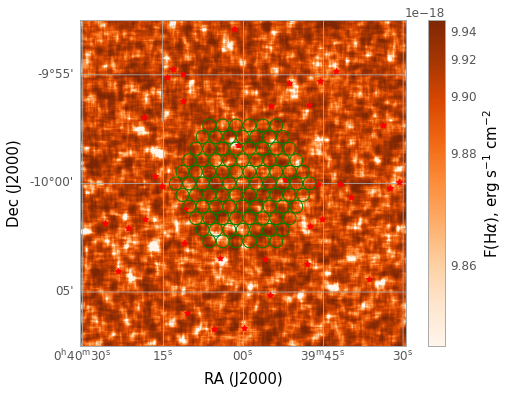

In [19]:
bundle = FiberBundle(bundle_name='full', nrings=5, angle=0, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers)


Then, we have an example of a ```diagonals``` array with nrings=5 and nrings=9

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using a diagonal pattern of fibers.
[INFO]: Using the inner 5 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.
[WARNING]: Bundle center coords are not defined, using the coords of the field.


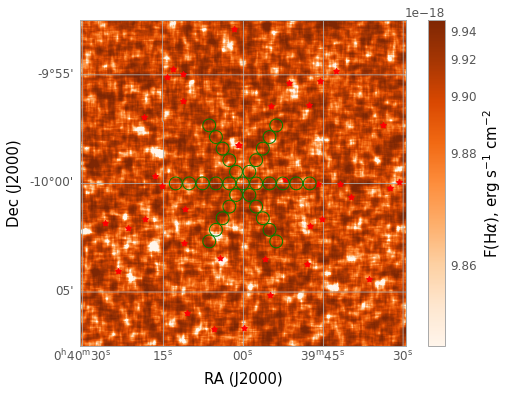

In [20]:
bundle = FiberBundle(bundle_name='diagonals', nrings=5, angle=0, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers)

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using a diagonal pattern of fibers.
[INFO]: Using the inner 9 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.
[WARNING]: Bundle center coords are not defined, using the coords of the field.


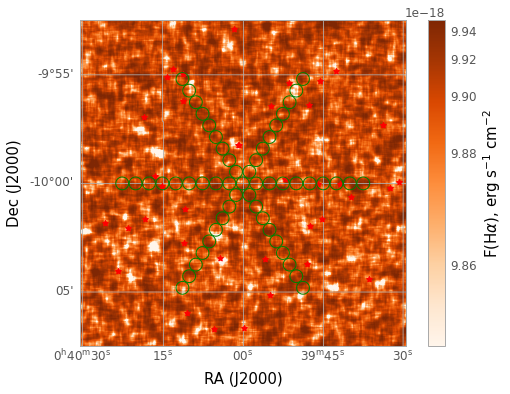

In [21]:
bundle = FiberBundle(bundle_name='diagonals', nrings=9, angle=0, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers)

Finally, an example of an ``horizontal`` array

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using an horizontal line of fibers.
[INFO]: Using the inner 10 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.
[WARNING]: Bundle center coords are not defined, using the coords of the field.


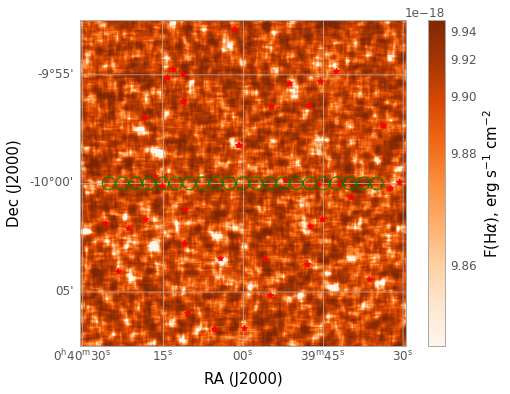

In [22]:
bundle = FiberBundle(bundle_name='horizontal', nrings=10, angle=0, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers, outname='horizontal_10.png')

Fiber bundles can also be rotated with the ``angle`` argument. The rotations proceeds counter clockwise. 

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using an horizontal line of fibers.
[INFO]: Using the inner 10 exagonal rings.
[INFO]: Rotating the bundle to PA = 45 deg.
[WARNING]: Bundle center coords are not defined, using the coords of the field.


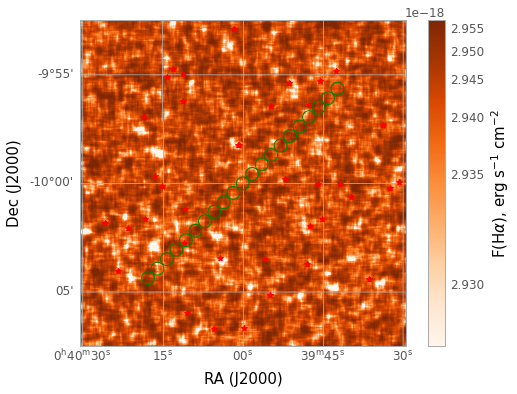

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using an horizontal line of fibers.
[INFO]: Using the inner 10 exagonal rings.
[INFO]: Rotating the bundle to PA = 90 deg.
[WARNING]: Bundle center coords are not defined, using the coords of the field.


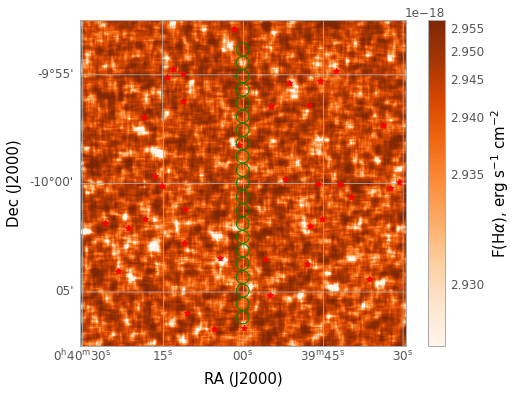

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using a diagonal pattern of fibers.
[INFO]: Using the inner 10 exagonal rings.
[INFO]: Rotating the bundle to PA = 90 deg.
[WARNING]: Bundle center coords are not defined, using the coords of the field.


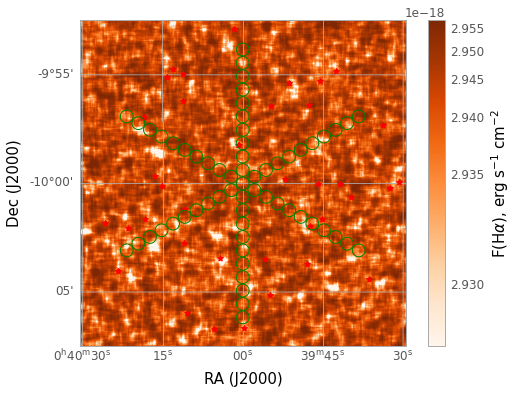

In [40]:
bundle = FiberBundle(bundle_name='horizontal', nrings=10, angle=45, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers)

bundle = FiberBundle(bundle_name='horizontal', nrings=10, angle=90, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers)

bundle = FiberBundle(bundle_name='diagonals', nrings=10, angle=90, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers)

To simulate the full 1801 fibers of the scientific array ``bundle_name`` should be set to ``full`` and ``nrings`` to 24 or more. If ``nrings > 24``, all the fibers in the array will be used. 

**Note: in this example, the bundle we are simulating is larger than the source field, and we will not use such a large bundle for the final simulation in this tutorial. In any case, all the fibers that are not overlapping with the FOV are automatically removed during the spectra extraction.**

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using the full hexagon pattern
[INFO]: Using the inner 24 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.
[WARNING]: Bundle center coords are not defined, using the coords of the field.


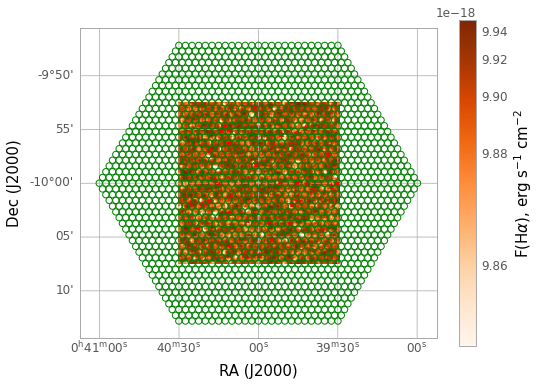

In [24]:
bundle = FiberBundle(bundle_name='full', nrings=24, angle=0, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers)

## Part 2: setting up the observation and sky conditions

Most of the properties of the observations and sky conditions, can be set up by using the **Observation** class.
This object requires the coordinates of the field to be observed, their units of measurement and a list of exposure times. Multiple exposure times can be simulated during a single run of the simulator. While typically the coordinates provided to the Observation class will be the same provided to the **LVMField**, it is possible to provide slightly different coordinates, to simulate "dithering", or to put specific location of the field into the central fiber. 

**N.B.: So far, the simulator supports a single fiber bundle position per run. To simulate a dithering pattern, multiple runs of the simulator should be used.** 

Finally, there are a few other optional parameters that can be used to modify the properties of the observations. These parameters are:

- ``time``,
- ``utcoffset``,
- ``exptimes``,
- ``airmass``,
- ``days_moon``,
- ``sky_template``.

As a default, time, utcoffset and the bundle center coordinates will be used to determine the lunar phase, the sky brightness, and the airmass of the target during the observations. However, the airmass of the target can be manually provided, as well as the moon phase (using the days_moon parameter). If the latter is provided, the sky template will be selected according to the moon phase. Finally, a completely custom sky template can be used by providing the path to the file using the sky_template parameter.

The following line shows how to initialize the Observation class with standard sky and atmospheric conditions:

In [25]:
obs = Observation(ra=10, dec=-10, unit_ra=u.deg, unit_dec=u.deg, exptimes=[900])
print(obs.time)
print(obs.airmass)
print(obs.days_moon)

2022-01-01T00:00:00.000
1.117749510401084
2


In the following example, we define the exact time of the observations, and we see that the other properties like airmass and days_moon will change

In [26]:
obs = Observation(ra=10, dec=-10, unit_ra=u.deg, unit_dec=u.deg, exptimes=[900],
                  time='2022-05-20T09:33:25.00')
print(obs.time)
print(obs.airmass)
print(obs.days_moon)

2022-05-20T09:33:25.000
1.926054695122364
10


Similarly, we can manually provide the airmass and the moon phase as follows:

In [27]:
obs = Observation(ra=10, dec=-10, unit_ra=u.deg, unit_dec=u.deg, exptimes=[900],
                  airmass=1.3, days_moon=7)
print(obs.time)
print(obs.airmass)
print(obs.days_moon)

2022-01-01T00:00:00.000
1.3
7


Finally, a sky template can be directly provided by passing the name of the file as follows:

```obs = Observation(ra=10, dec=-10, unit_ra=u.deg, unit_dec=u.deg, exptimes=[900], sky_template='/path/to/file')```

The file must be a simple ascii file with two columns, where the first one is the wavelength (in Angstrom) and the second one is the sky emission in surface brightness units (in erg / cm2 * s * AA * arcsec2). 

It is possible to simulate multiple exposure times in a single simulator run by providing a list of exposure times in seconds:

In [28]:
obs = Observation(ra=10, dec=-10, unit_ra=u.deg, unit_dec=u.deg, exptimes=[900, 3*900, 20*900])

## Part 3: Outputs

Now we will analize the output of the simulations. As a first step, we run a simple simulations:

In [29]:
my_lvmfield = LVMField(ra=10, dec=-10, size=15, spaxel=1, unit_ra=u.degree,
                       unit_dec=u.degree, unit_size=u.arcmin, unit_spaxel=u.arcsec, name='LVM_test')

my_lvmfield.generate_gaia_stars(filename='LVM_test_starlist.fits.gz')
my_lvmfield.add_nebulae(load_from_file="testneb_tutorial1.fits")

tel = LVM160()
spec = LinearSpectrograph()
bundle = FiberBundle(bundle_name='full', nrings=10, angle=0, custom_fibers=None)
obs = Observation(ra=10, dec=-10, unit_ra=u.deg, unit_dec=u.deg, exptimes=[900])

sim = Simulator(my_lvmfield, obs, spec, bundle, tel)
sim.simulate_observations()
sim.save_outputs()

[INFO]: Reading the star list from file ./LVM_test_starlist.fits.gz
[INFO]: Nebulae successfully loaded from file
[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using the full hexagon pattern
[INFO]: Using the inner 10 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.
[INFO]: Simulating observations.
[INFO]: Reading the atmospheric extinction from file.
[INFO]: Resample extinction file to instrument wavelength solution.
[INFO]: Simulating the sky emission 2 days from new moon.
[INFO]: Using sky file: /mnt/DATA/LVM/lvmdatasimulator/data/sky/LVM_LVM160_SKY_2.dat
[INFO]: Resample sky emission to instrument wavelength solution.
[INFO]: Recovering target spectra for 331 fibers.
[INFO]: Start extracting nebular spectra
  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--[INFO]: Dividing the array in 4 with an overlap of 40.7 arcsec
100% (1 of 1) |##########################| Elapsed Time: 0:01:02 Time:  0:01:02
[INFO]: Re

We can also save input and output maps as follows:

In [30]:
my_lvmfield.get_map(wavelength_ranges=[[6550, 6570], [5000, 5020]])  # Input maps

sim.save_output_maps(wavelength_ranges=[[6550, 6570], [5000, 5020]])  # Output maps

[INFO]: Input image in 6550.0-6570.0AA wavelength range is saved to LVM_test_6550_6570_input_map.fits
[INFO]: Input image in 5000.0-5020.0AA wavelength range is saved to LVM_test_5000_5020_input_map.fits
[INFO]: Saving the 2D output maps
[INFO]:  Saving ./outputs/LVM_test_linear_full_6550_6570_900s_target_map.fits...
[INFO]:  Saving ./outputs/LVM_test_linear_full_6550_6570_900s_total_map.fits...
[INFO]:  Saving ./outputs/LVM_test_linear_full_5000_5020_900s_target_map.fits...
[INFO]:  Saving ./outputs/LVM_test_linear_full_5000_5020_900s_total_map.fits...
[INFO]:  Saving ./outputs/LVM_test_fibers.reg...


In both cases, multiple images can be extracted at the same time by providing multiple wavelength ranges. So far, **it is not possible to extract images using filter sensitivity curves**, we may add this capability in the future.

The first thing to notice is that the outputs of ``my_lvmfield.get_map()`` will be saved in the *work* directory, while the outputs of ``sim.save_outputs()`` and ``sim.save_output_maps()`` will be saved in the *output* directory, located inside the work directory.

The input maps will be named using the following convention:

```{my_lvmfield.name}_{wavelength_range[0]}_{wavelength_range[1]}_input_map.fits```

and they contain a view of the source field integrated across the selected wavelength range. The images contain a single extension with a WCS in the header, and they can be easily opened with DS9 or with python. For example:

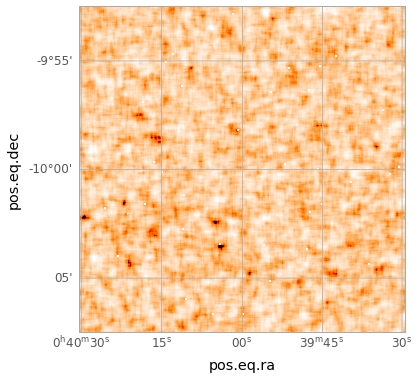

In [31]:
import astropy.visualization as vis
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS

with fits.open('./LVM_test_6550_6570_input_map.fits') as hdu:
    image = hdu[0].data
    wcs = WCS(hdu[0].header)
    
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=wcs))

interval = vis.PercentileInterval(99.9)
vmin,vmax = interval.get_limits(image)
norm = vis.ImageNormalize(vmin=vmin, vmax=vmax, stretch=vis.LogStretch(1000))
ax.imshow(image, norm=norm)

plt.show()

The ``sim.save_output_maps()`` command saves two different output files for each wavelength range. The first one contains the total simulated emission (sky+object) in the wavelength range, while the second one contains only the sky subtracted emission. To have a better view of the results of the simulation, the flux observed by each fiber is reported in circular areas (with the same diameter and position of the fiber). Each pixel inside each circle shows the total flux observed by that fiber. So, **these are not scientific outputs, but they allow for a qualitative comparison with the input maps**.

The target and total maps are named following this naming convention:

```{my_lvmfield.name}_linear_{bundle_name}_{wavelength_range[0]}_{wavelength_range[1]}_{exptime}s_target_map.fits```
```{my_lvmfield.name}_linear_{bundle_name}_{wavelength_range[0]}_{wavelength_range[1]}_{exptime}s_total_map.fits```

These images contain a single extension too, and they can easily be opened by DS9 or python, as follows:

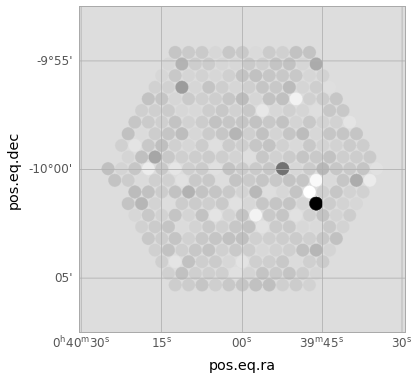

In [32]:
with fits.open('./outputs/LVM_test_linear_full_6550_6570_900s_target_map.fits') as hdu:
    image = hdu[0].data
    wcs = WCS(hdu[0].header)
    
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=wcs))

interval = vis.PercentileInterval(99.9)
vmin,vmax = interval.get_limits(image)
norm = vis.ImageNormalize(vmin=vmin, vmax=vmax, stretch=vis.LogStretch(1000))
ax.imshow(image, norm=norm, cmap='Greys')

plt.show()

The simulator also saves the position of the fibers in a DS9 region file named:

```./outputs/{my_lvmfield.name}_fibers.reg```

This allow for an easier comparison between the output maps and the input map.

Finally, the main output of the simulator are three files containing different versions of the simulated spectra. They are named as:

```./outputs/{my_lvmfield.name}_linear_{bundle_name}_input.fits```
```./outputs/{my_lvmfield.name}_linear_{bundle_name}_{exptime}_realization.fits```
```./outputs/{my_lvmfield.name}_linear_{bundle_name}_{exptime}_flux.fits```

The first file "*_input.fits", saves the spectra extracted from the source field. They are resampled to the instrument wavelength range, but they are not further processed. These are for reference, and to compare with the real output of the codes. So far, it is not possible to re-run a different simulation using these spectra as an input without extracting them again from the source field, but we are planning to make it possible in the future.

This files contains 5 different extensions:
- a PRIMARY extension which contains all the relevant information abut the simulation and the source field in the header
- a FLUX extension. It is an array where each line correspond to a spectrum. This extension contains only the flux of the target.
- a SKY extension. It is an array where each line correspond to a spectrum. This extension contains only the sky emission.
- a WAVE extension. To this stage, it is a 1D array containing the wavelength axis for all spectra.
- a FIBERID extension. This is a table, and contains the information on the fibers. It can be used to identify which spectrum correspond to each fiber. Their order is the same as the order of the spectra.

This file can be open with DS9 for a qualitative check, but DS9 will not be able to open the FIBERID extension since it is a table. It is also possible to plot each single spectra with python. We give an example as follows:

In [33]:
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

filename = './outputs/LVM_test_linear_full_input.fits'

with fits.open(filename) as hdu:
    wave = hdu['WAVE'].data
    fiberid = Table.read(hdu['FIBERID'])
    flux = hdu['FLUX'].data
    
print(fiberid)   # this is a table

 id ring position ...           y            diameter dispersion
                  ...         arcsec          arcsec     pix    
--- ---- -------- ... ---------------------- -------- ----------
  0    0        0 ...                    0.0     35.3        3.0
  1    1        0 ...    -32.042939553375824     35.3        3.0
  2    1        1 ...     -32.04293955337582     35.3        3.0
  3    1        2 ... 1.2632342130702194e-11     35.3        3.0
  4    1        3 ... 1.2623279744534303e-11     35.3        3.0
  5    1        4 ...     32.042939553401084     35.3        3.0
  6    1        5 ...      32.04293955340108     35.3        3.0
  7    2        0 ...      -64.0858767868585     35.3        3.0
  8    2        1 ...     -64.08587781791653     35.3        3.0
  9    2        2 ...     -64.08587678685849     35.3        3.0
...  ...      ... ...                    ...      ...        ...
321   10       50 ...      320.4290591497984     35.3        3.0
322   10       51 ...    

Once the file is open, the ``fiberid`` table can be used to select a specific fiber, by applying different masks

In [34]:
mask = fiberid['id'] == 200

spectrum = flux[mask][0]  # select only fiber n. 200

Now it is possible to plot the spectrum as a normal matplotlib plot

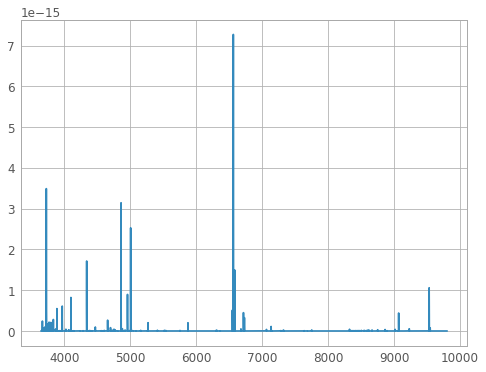

In [35]:
plt.plot(wave, spectrum)

plt.show()

The second and third files ("_realization.fits", "_flux.fits") basically contains the same information and the same file structure. The difference between the two files is the unit of measurement of the fluxes. "_realization.fits" contains spectra and errors in counts/s, so they simulates the spectra extracted from the wavelength calibrated image, but still **not** flux calibrated or corrected for telluric absorption. In "_flux.fits" on the other hand, the spectra are flux and telluric calibrated, so they simulate the otuput of the data reduction pipeline and they should be ready to be feed to the data analysis pipeline.

These two files contains 8 extensions:

- the PRIMARY extension contains the usual info on the simulation
- the TARGET extension is an array where each line correspond to a spectrum. It contains the sky subtracted simulated spectra (resampled, passed through atmosphere, the instrument etc) with noise. 
- the TOTAL extension is an array where each line correspond to a spectrum. It contains the simulated spectra (resampled, passed through atmosphere, the instrument etc) with noise of targets+sky.
- the ERR extension is an array where each line correspond to a spectrum. It contains the error spectrum
- the SNR extension is an array where each line correspond to a spectrum and it contains the signal to noise as a function of wavelength
- the SKY extension is an array where each line correspond to a spectrum and it contains the sky spectra with noise
- the WAVE extension. To this stage, it is a 1D array containing the wavelength axis for all spectra.
- the FIBERID extension. This is a table, and contains the information on the fibers. It can be used to identify which spectrum correspond to each fiber. Their order is the same as the order of the spectra.  

There is no function or class to read and open the output spectra, but they can be easily examined using basic python functions as shown for the "_input.fits" file.

This concludes the tutorial.